In [1]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

TODO:
+ Maybe label parameters on custom route plots
+ Possibly give each route type it's own sub-heading?
+ Manual routing example

# Routing

Often when creating a design, there's the need to connect geometries together with wires or waveguides.  To help with that, PHIDL has a `phidl.routing` (`pr`) module that can flexibly and quickly create routes between ports.

## Simple quadrilateral routing using `pr.route_quad()`

An easy way to make simple routes is by using `pr.route_quad()`, which directly connects two ports with a quadrilateral polygon. This works particularly well for electrical wiring, because it creates compact connections.

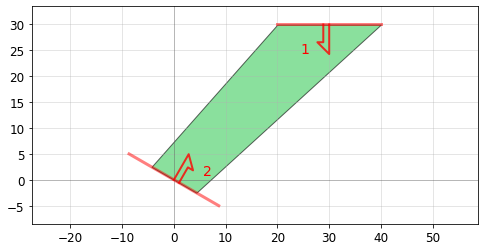

In [2]:
from phidl import Device
from phidl import quickplot as qp
from phidl import set_quickplot_options
import phidl.routing as pr

set_quickplot_options(show_ports=True, show_subports=False)

D = Device()
port1 = D.add_port(name=1, midpoint=(30, 30), width=20, orientation=270)
port2 = D.add_port(name=2, midpoint=(0, 0), width=20, orientation=60)

D.add_ref(pr.route_quad(port1, port2, width2 = 10))
qp(D)

## Automatic manhattan routing using `pr.route_smooth()` and `pr.route_sharp()`

Often, straight-shot quadrilateral routes aren't good enough. For example, maybe:
+ the ports face away from each other, or
+ we want to route waveguides with well-defined smooth bends, or
+ we want to use a manhattan routing style (i.e. vertical and horizontal lines) for neatness.

In these cases, we can use `pr.route_smooth()` (e.g. for waveguides) or `pr.route_sharp()` (e.g. for electrical wiring). By setting `path_type='manhattan'`, these route functions will automatically create a manhattan route between ports, as long as those ports are parrallel or orthogonal:

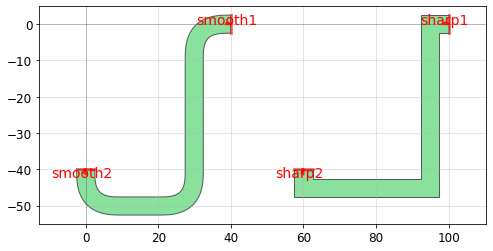

In [3]:
D = Device()
port1 = D.add_port(name='smooth1', midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name='smooth2', midpoint=(0, -40), width=5, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='manhattan', layer=0))

port3 = D.add_port(name='sharp1', midpoint=(100,0), width=5, orientation=180)
port4 = D.add_port(name='sharp2', midpoint=(60, -40), width=5, orientation=270)
D.add_ref(pr.route_sharp(port3, port4, path_type='manhattan', layer=0))

qp(D)

`pr.route_smooth()` works in three steps:
1. calculate a route `Path` using the pathing function set by `path_type` (e.g. `pr.path_manhattan()`),
2. smooth out the route `Path` using `pp.smooth()`, and
3. extrude the route `Path` to create the route geometry.

`route_sharp()` works similarly, but it omits step 2 (smoothing) to create sharp bends. 

For example, `route_smooth(path_type='manhattan')` is equivalent to something like this:

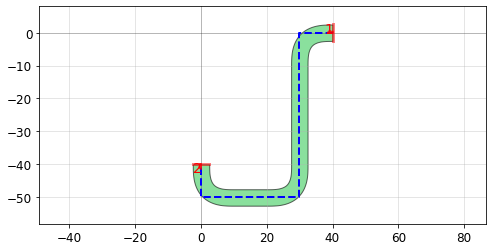

In [4]:
from phidl import CrossSection
import phidl.path as pp

D = Device()
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

route_path = pr.path_manhattan(port1, port2, radius=10) # radius parameter ensures enough room for bends created by pp.smooth
smoothed_path = pp.smooth(route_path, radius=10, use_eff=True)
D.add_ref(smoothed_path.extrude(width=5, layer=0))
qp([route_path,D])

These routing functions `pr.route_smooth()` and `pr.route_sharp()` have arguments that allow us to customize how they complete these steps:

__Example 1: Routing with arbitrary `CrossSection`.__ By default with `width=None`, these routing functions will extrude the route path with a width that tapers linearly between the port widths. However, we can also pass any `width` argument we like onward to `Path.extrude()`. For example, we can extrude a custom `CrossSection` with multiple layers:

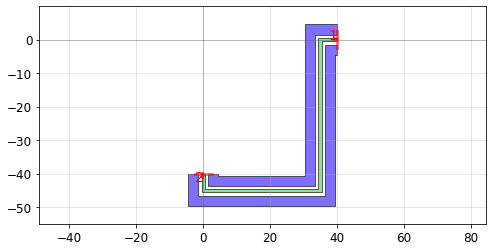

In [5]:
D = Device()
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)
X = CrossSection().add(width=1, layer=0)
X.add(width=3,offset=3, layer=1)
X.add(width=3, offset=-3, layer=1)
D.add_ref(pr.route_sharp(port1, port2, path_type='manhattan', width=X))

qp(D)

__Example 2: Adjusting `pp.smooth()` options to make circular bends.__ We can customize the bends produced by `pr.route_smooth()` using the `smooth_options`, which are passed to `pp.smooth()`.

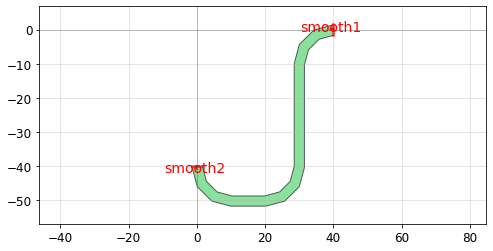

In [7]:
D = Device()
port1 = D.add_port(name='smooth1', midpoint=(40,0), width=3, orientation=180)
port2 = D.add_port(name='smooth2', midpoint=(0, -40), width=3, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, radius=10, smooth_options={'corner_fun': pp.arc, 'num_pts': 16}, layer=0))
qp(D)

## Customizing routes

Sometimes, automatic routes will run into another device in your layout, like this:

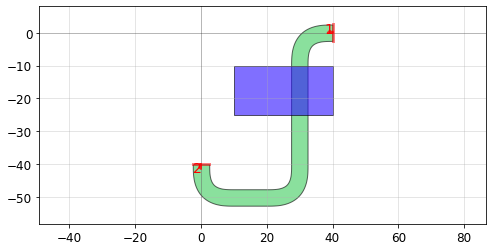

In [11]:
import phidl.geometry as pg

set_quickplot_options(show_ports=True, show_subports=False)

D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='manhattan', layer=0))
qp(D)

__Example 1: Custom `J` paths.__ To avoid the other device, we need to create a custom route. PHIDL provides several pathing functions to help you quickly make custom routes. All the available path types are described below, but in this case, we want a `J`-path. We can tell `route_smooth` to use `pr.path_J()` as its pathing function via the argument `path_type='J'`.

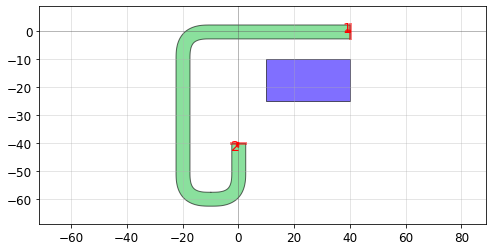

In [12]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=180)
port2 = D.add_port(name=2, midpoint=(0, -40), width=5, orientation=270)

D.add_ref(pr.route_smooth(port1, port2, radius=10, path_type='J', length1=60, length2=20, layer=0))
qp(D)


For ease of use, the `pr.path_***` pathing functions are parameterized in terms of relative distances from ports. Above, we set `length1` and `length2`, which define the lengths of the line segments that exit `port1` and `port2` respectively (i.e. the first and last sements in the path). Once those first and last segments are set, `path_J()` then completes the `Path` by connecting the segments with two more segments at right angles. 

__Example 2: Custom `C` paths.__ Now consider this routing problem:

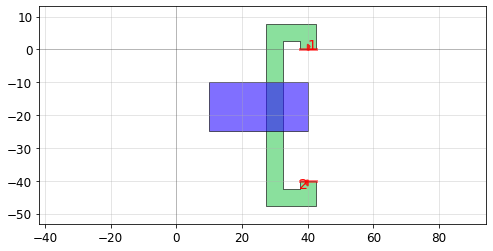

In [32]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=90)
port2 = D.add_port(name=2, midpoint=(40, -40), width=5, orientation=270)

D.add_ref(pr.route_sharp(port1, port2, path_type='manhattan', layer=0))
qp(D)

In this case, we want a `C` path (again, see below for all the path types). `C` paths have three parameters we need to define: 
+ `length1` and `length2`, which are the length of the segments that exit `port1` and `port2` (just as with the `J` path), as well as 
+ `left1`, which is the length of the segment that turns *left* from `port1`. 

In this case, we would actually prefer that the path turns *right* after it comes out of `port1`. To make that happen, we can just set `left1<0`:

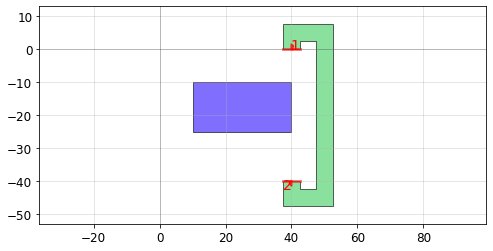

In [37]:
D = Device()
other_device = D.add_ref(pg.rectangle(size=(30,15),layer=1))
other_device.move((10, -25))
port1 = D.add_port(name=1, midpoint=(40,0), width=5, orientation=90)
port2 = D.add_port(name=2, midpoint=(40, -40), width=5, orientation=270)

D.add_ref(pr.route_sharp(port1, port2, path_type='C', length1=5, length2=5, left1=-10, layer=0))
qp(D)

## Routing path types

PHIDL provides the following path types for routing. 

| Path type   | Routing style| Segments   | Useful for ... | Parameters |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| `straight`  | Manhattan   | 1           | ports that point directly at each other.| -- |
| `L`         | Manhattan   | 2           | orthogonal ports that can be connected with one turn.| -- |
| `U`         | Manhattan   | 3           | parrallel ports that face each other or same direction.| `length1` |
| `J`         | Manhattan   | 4           | orthogonal ports that can't be connected with just one turn.| `length1`, `length2` |
| `C`         | Manhattan   | 5           | parrallel ports that face apart.| `length1`, `length2`, `left1` |
| `manhattan` | Manhattan   | 1-5         | parrallel or orthogonal ports.| `radius` |
| `V`         | Free        | 2           | ports at odd angles that face a common intersection point.| -- |
| `Z`         | Free        | 3           | ports at odd angles.| `length1`, `length2` |

Most path types are named after letters that they resemble to help you remember them. However, as you'll see in the examples below, some of the more complicated paths can take a variety of shapes. One good way to identify which Manhattan route type you need is to count the number of line segments and consult the above table.



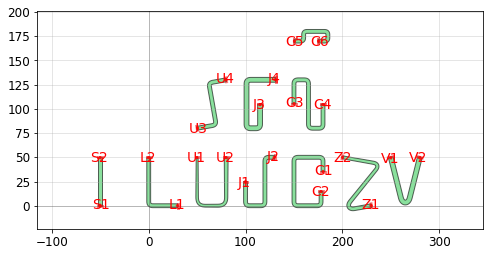

In [82]:
D = Device()

#straight path
port1 = D.add_port(name='S1', midpoint=(-50, 0), width=4, orientation=90)
port2 = D.add_port(name='S2', midpoint=(-50, 50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='straight'))
#L path
port1 = D.add_port(name='L1', midpoint=(30,0), width=4, orientation=180)
port2 = D.add_port(name='L2', midpoint=(0, 50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2,  path_type='L'))
#U path
port1 = D.add_port(name='U1', midpoint=(50, 50), width=2, orientation=270)
port2 = D.add_port(name='U2', midpoint=(80,50), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2,  radius=10, path_type='U', length1=50))
port1 = D.add_port(name='U3', midpoint=(50, 80), width=4, orientation=10)
port2 = D.add_port(name='U4', midpoint=(80, 130), width=4, orientation=190)
D.add_ref(pr.route_smooth(port1, port2,  path_type='U', length1=20))
#J path
port1 = D.add_port(name='J1', midpoint=(100, 25), width=4, orientation=270)
port2 = D.add_port(name='J2', midpoint=(130, 50), width=4,  orientation=180)
D.add_ref(pr.route_smooth(port1, port2,  path_type='J', length1=25, length2=10))
port1 = D.add_port(name='J3', midpoint=(115, 105), width=5, orientation=270)
port2 = D.add_port(name='J4', midpoint=(131, 130), width=5,  orientation=180)
D.add_ref(pr.route_smooth(port1, port2, path_type='J', length1=25, length2=30))
#C path
port1 = D.add_port(name='C1', midpoint=(180, 35), width=4, orientation=90)
port2 = D.add_port(name='C2', midpoint=(178, 15), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=15, left1=30, length2=15))
port1 = D.add_port(name='C3', midpoint=(150, 105), width=4, orientation=90)
port2 = D.add_port(name='C4', midpoint=(180, 105), width=4, orientation=270)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=25, left1=-15, length2=25))
port1 = D.add_port(name='C5', midpoint=(150, 170), width=4, orientation=0)
port2 = D.add_port(name='C6', midpoint=(175, 170), width=4, orientation=0)
D.add_ref(pr.route_smooth(port1, port2, path_type='C', length1=10, left1=10, length2=10, radius=4))
#Z path
port1 = D.add_port(name='Z1', midpoint=(230,0), width=4, orientation=190)
port2 = D.add_port(name='Z2', midpoint=(200, 50), width=3, orientation=-10)
D.add_ref(pr.route_smooth(port1, port2, path_type='Z', length1=30, length2=40))
#V path
port1 = D.add_port(name='V1', midpoint=(250,50), width=5, orientation=284)
port2 = D.add_port(name='V2', midpoint=(280, 50), width=5, orientation=270-14)
D.add_ref(pr.route_smooth(port1, port2, path_type='V'))

qp(D)

The `manhattan` path type is bending-radius aware and can produce any route neccessary to connect two ports, as long as they are orthogonal or parrallel. 

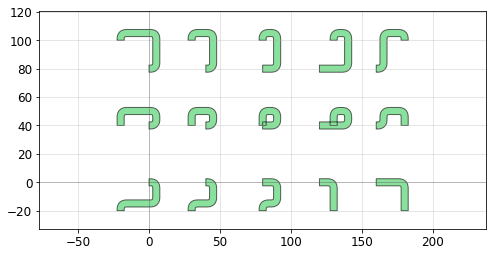

In [91]:
import numpy as np

set_quickplot_options(show_ports=False, show_subports=False)

D = Device() 
pitch = 40
test_range=20
xdevs = np.arange(5)*pitch
ydevs = np.arange(3)*pitch
xtest = np.linspace(-1*test_range, test_range, 5)
ytest = np.linspace(-1*test_range, test_range, 3)
for xidx, xdev in enumerate(xdevs):
    for yidx, ydev in enumerate(ydevs):
        devname = '{}{}'.format(xidx, yidx)
        port1 = D.add_port(name=devname+'1', midpoint=(xdev, ydev), width=5, orientation=0)
        port2 = D.add_port(name=devname+'2', midpoint=(xdev+xtest[xidx], ydev+ytest[yidx]), 
                           width=5,  orientation=90)
        D.add_ref(pr.route_smooth(port1, port2, route_type='manhattan'))
qp(D)